In [62]:
# Import modules
import glob
import numpy as np
from os import makedirs
from pandas import DataFrame
import matplotlib.pyplot as plt
from impedance import preprocessing
from galvani.BioLogic import MPRfile
from impedance.models.circuits import CustomCircuit, Randles
from impedance.visualization import plot_nyquist, plot_bode, plot_residuals

In [63]:
# Convert data from mpr file into csv
filename = glob.glob('*.mpr')[0]
data = DataFrame(MPRfile(filename).data)
freq = data['freq/Hz']
real_Z = data['Re(Z)/Ohm']
imag_Z = -1*data['-Im(Z)/Ohm']
np.savetxt('data.csv', np.column_stack((freq, real_Z, imag_Z)), delimiter=',')

In [64]:
# Read from csv file and pre-process
frequencies, Z = preprocessing.readCSV('data.csv')
frequencies, Z = preprocessing.ignoreBelowX(frequencies, Z)
# mask = frequencies <= 1e5
# frequencies = frequencies[mask]
# Z = Z[mask]

In [65]:
# Define circuit with iniital values
foldername = 'C3'

# circuit = CustomCircuit('R0-p(R1,C1,CPE0)-p(R2,C2)', initial_guess=[18, 500, 0.0001, 20, 1.0, 100, 0.001])
# circuit = CustomCircuit('R0-p(R1,CPE0)-p(R2,C2)', initial_guess=[18, 500,0.0001,0.99, 100,0.001])
circuit = CustomCircuit('R0-p(R1,CPE0)-W', initial_guess=[18, 500,0.0001,0.99, 100])




# Some other trial circuits
# circuit = CustomCircuit('R0-p(R1,C1,G0)-p(R2,C2)', initial_guess=[18, 500,0.0001,20,1, 100,0.001])
# circuit = Randles(initial_guess=[0.1, 10, .1, .9, .001, 200], CPE=True)


# Fit to circuit and write outputs
circuit.fit(frequencies, Z, global_opt=False)
print(circuit)
makedirs(foldername, exist_ok=True)
circuit.save(foldername+'/circuit.json')
file = open(foldername+'/out.txt', 'w')
file.write(str(circuit))
file.close()


# Compute residuals
res_real = (Z - circuit.predict(frequencies)).real/np.abs(Z)
res_imag = (Z - circuit.predict(frequencies)).imag/np.abs(Z)



Circuit string: R0-p(R1,CPE0)-W
Fit: True

Initial guesses:
     R0 = 1.80e+01 [Ohm]
     R1 = 5.00e+02 [Ohm]
  CPE0_0 = 1.00e-04 [Ohm^-1 sec^a]
  CPE0_1 = 9.90e-01 []
      W = 1.00e+02 [Ohm sec^-1/2]

Fit parameters:
     R0 = 1.15e+01  (+/- 7.54e-01) [Ohm]
     R1 = 5.06e+02  (+/- 1.80e+00) [Ohm]
  CPE0_0 = 1.90e-05  (+/- 4.43e-07) [Ohm^-1 sec^a]
  CPE0_1 = 8.90e-01  (+/- 4.38e-03) []
      W = 4.97e+01  (+/- 1.55e+00) [Ohm sec^-1/2]



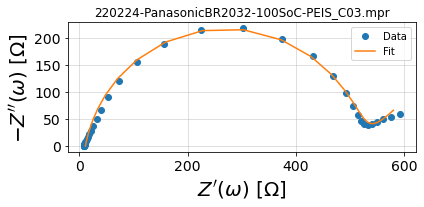

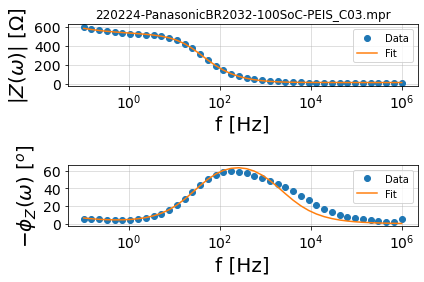

In [69]:
# Plot Nyquist
fig, ax = plt.subplots(tight_layout=True, facecolor='w')
plot_nyquist(ax, Z, fmt='o', units='\Omega', label='Data')
plot_nyquist(ax, circuit.predict(frequencies), fmt='-', units='\Omega', label='Fit')
plt.legend()
plt.title(filename)
fig1 = plt.gcf()
fig1.savefig(foldername+'/nyquist.png', bbox_inches='tight', dpi=200)
plt.show()
plt.close()


# Plot Bode
fig, ax = plt.subplots(2, 1, tight_layout=True, facecolor='w')
plot_bode(ax, frequencies, Z, fmt='o', units='\Omega', label='Data')
plot_bode(ax, frequencies, circuit.predict(frequencies), fmt='-', units='\Omega', label='Fit')
ax[0].set_title(filename)
ax[0].legend()
ax[1].legend()
plt.savefig(foldername+'/bode.png', bbox_inches='tight', dpi=200)
plt.show()
plt.close()

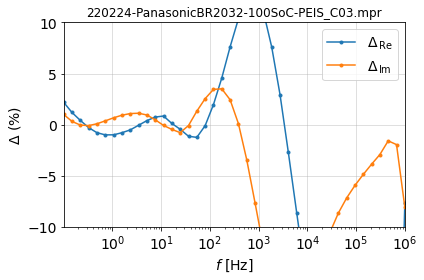

In [70]:
# Plot residuals
fig, ax = plt.subplots(tight_layout=True, facecolor='w')
plot_residuals(ax, frequencies, res_real, res_imag, y_limits=(-10,10))
plt.title(filename)
plt.savefig(foldername+'/residuals.png', bbox_inches='tight', dpi=200)
plt.show()
plt.close()